# Basismodell als gemeinsamer Startpunkt für Semesterprojekte (losgelöste Aufgabenstellung ebenfalls möglich)

## Basismodell
Bewertung von Photovoltaik-Anlagen zur Deckung des Eigenbedarfs inkl. Batteriespeicher

In [30]:
# Import necessary libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
from demandlib import bdew
from geopy.geocoders import Nominatim






## Annahmen und Optionen

In [31]:
yearly_demand = 3000 # kWh
pv_installed_power = 10 # kWp
selected_location = "Universitätsstraße 12, 45141 Essen"

c_feedin = 0.082 # €/kWh bis 10kWp 8,2 ct/kWh, bis 40kWp 7,1 ct/kWh https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/ErneuerbareEnergien/ZahlenDatenInformationen/EEG_Registerdaten/start.html
c_pur = 0.35 # €/kWh

P_bat = 10 # kW
E_bat = 20 # kWh
eta_bat = 0.9 # Wirkungsgrad

selected_year = 2019

## Datenbezug und -aufbereitung

### Erzeugung eines Lastprofils
- Standardlastprofil für Haushalte
- Verwendung von demandlib
- Jahresverbrauch in kWh


In [32]:
e_slp = bdew.ElecSlp(selected_year)
elec_demand = e_slp.get_profile({"h0": yearly_demand})

### Erstelle Erzeugungsprofil für PV-Anlage
- Verwendung von pvgis api

In [33]:
# Erstelle Erzeugungsprofil für PV-Anlage

geolocator = Nominatim(user_agent="EuerName")
location = geolocator.geocode(selected_location)


# API-Abfrage
url = "https://re.jrc.ec.europa.eu/api/v5_2/seriescalc"

# Parameter
params = {
    "lat": location.latitude,
    "lon": location.longitude,
    "startyear": selected_year,
    "endyear": selected_year,
    "pvcalculation": 1,
    "peakpower": pv_installed_power,    # kWp
    "loss": 10,
    "outputformat": "json",
}

# Abfrage
r = requests.get(url, params=params)
data = r.json()

# Erstelle DataFrame
elec_pv = pd.DataFrame(data["outputs"]["hourly"])
elec_pv.index = pd.to_datetime(elec_pv["time"], format="%Y%m%d:%H10")
# remove all columns except "P"
elec_pv = elec_pv[["P"]]


In [34]:
# Erstelle ein DataFrame mit dem Lastprofil und dem Erzeugungsprofil
energiesystem = pd.DataFrame()
energiesystem["demand"] = elec_demand
energiesystem["pv"] = elec_pv["P"] / 1000 # kW

# Konvertiere in stündliche Werte
energiesystem = energiesystem.resample("h").mean()

# summe von demand und pv, gerundet ohne Kommastellen
print(f"Summe des Lastprofils: {energiesystem['demand'].sum():.0f}")
print(f"Summe des PV-Erzeugungsprofils: {energiesystem['pv'].sum():.0f}")


Summe des Lastprofils: 3000
Summe des PV-Erzeugungsprofils: 9152


Text(0.5, 1.0, 'Woche 23')

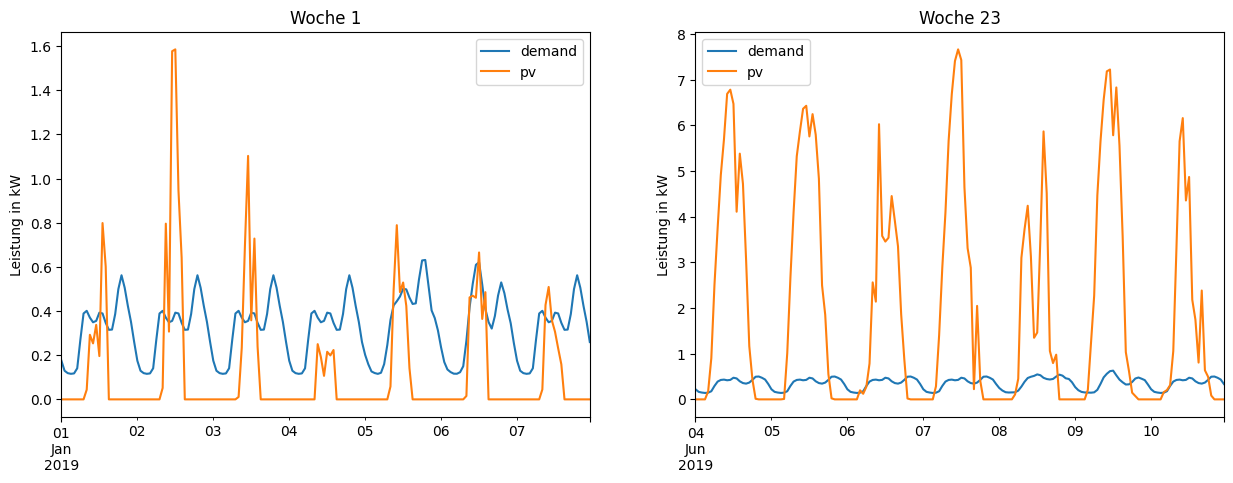

In [35]:
# Plotte das Lastprofil und das Erzeugungsprofil für zwei ausgewählte Wochen in subplots nebeneinander
week_no_left = 1
week_no_right = 23

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
energiesystem[(week_no_left-1)*24*7:week_no_left*24*7].plot(ax=ax1)
ax1.set_ylabel("Leistung in kW")
ax1.set_title("Woche " + str(week_no_left))

energiesystem[(week_no_right-1)*24*7:week_no_right*24*7].plot(ax=ax2)
ax2.set_ylabel("Leistung in kW")
ax2.set_title("Woche " + str(week_no_right))

# Berechnung der Eigenverbrauchsquote, Autarkiequote und Wirtschaftlichkeit



In [10]:
# Berechne den Eigenverbrauch
energiesystem["feedin"] = energiesystem["pv"] - energiesystem["demand"]
energiesystem["feedin"] = energiesystem["feedin"].clip(lower=0)

energiesystem["self_consumption"] = energiesystem["pv"] - energiesystem["feedin"]

energiesystem["electricity_purchase"] = energiesystem["demand"] - energiesystem["self_consumption"]

energiesystem.index.name = 't'

# Gib die Eigenverbrauchsquote aus
eigenverbrauchsquote = energiesystem["self_consumption"].sum() / energiesystem["pv"].sum() * 100
print(f"Eigenverbrauchsquote: {eigenverbrauchsquote:.0f} %")

# Gib die Autarkiequote aus
autharkiegrad = energiesystem["self_consumption"].sum() / energiesystem["demand"].sum() * 100
print(f"Autarkiegrad: {autharkiegrad:.0f} %")



Eigenverbrauchsquote: 16 %
Autarkiegrad: 49 %


# Aufstellung eines Optimierungsproblems

## Zielfunktion
- Minimierung der Kosten abzüglich der Einspeisevergütung
- Strombezug aus dem Netz $y^{pur}_t$
- Einspeisung in das Netz $y^{pv,feedin}_t$
- Einspeisevergütung $c^{feedin}$
- Bezugskosten $c^{pur}$
$$ \min \sum_{t=1}^{T} (y^{pur}_t \cdot c^{pur} \cdot {dt} - y^{pv,feedin}_t \cdot c^{feedin} \cdot {dt}) $$

## Nebenbedingungen
- Deckung der Nachfrage $D_t$ aus Netzbezug $y^{pur}_t$, PV Eigennutzung, $y^{pv,self}_t$ und Entladung Batterie $y^{s,dc}_t$
$$ y^{pur}_t + y^{pv,self}_t + y^{s,dc}_t - y^{s,ch}_t = D_t $$
- Aufteilung der gesamten PV-Erzeugung ${PV}_t$ in Eigennutzung $y^{pv,self}_t$ und Einspeisung $y^{pv,feedin}_t$
$$ y^{pv,self}_t + y^{pv,feedin}_t = {PV}_t $$

- Speicherfüllstandsrestriktionen (Speicherfüllstand $l^s_t$) mit Batteriekapazität $E^{bat}$, Lade-/Entladeleistung $P^{bat}$ und Wirkungsgrad $\eta_{bat}$
$$ y^{s,dc}_t <= P^{bat} $$
$$ y^{s,ch}_t <= P^{bat} $$
$$ l^s_t + y^{s,ch}_t \cdot \eta_{bat} \cdot {dt} - y^{s,dc}_t \cdot {dt} - l^s_{t+1}= 0 $$
$$ 0 <= l^s_t <= E^{bat} $$




In [11]:
# Vorbereitung des Optimierungsmodells

t = pd.Index(energiesystem.index, name='t')
dt = (t[1] - t[0]).total_seconds() / 3600  # time step width in hours

D_t = energiesystem["demand"].to_xarray()
PV_t = energiesystem["pv"].to_xarray()



ImportError: Missing optional dependency 'xarray'.  Use pip or conda to install xarray.

In [23]:
# Erstellung eines Optimierungsmodells



# Erstelle ein Modell
m = Model()

# Erstelle die Variablen
y_pur_t = m.add_variables(coords=[t], name="y_pur_t",lower=0)
y_pv_feedin_t = m.add_variables(coords=[t], name="y_pv_feedin_t",lower=0)
y_pv_self_t = m.add_variables(coords=[t], name="y_pv_self_t",lower=0)
y_s_ch_t = m.add_variables(coords=[t], name="y_s_ch_t",lower=0)
y_s_dc_t = m.add_variables(coords=[t], name="y_s_dc_t",lower=0)
l_s_t = m.add_variables(coords=[t], name="l_s_t",lower=0)

# Erstelle die Nebenbedingungen
m.add_constraints(y_pur_t + y_pv_self_t + y_s_dc_t - y_s_ch_t == D_t, name="demand")
m.add_constraints(y_pv_feedin_t + y_pv_self_t == PV_t, name="pv")
m.add_constraints(l_s_t + y_s_ch_t * eta_bat * dt - y_s_dc_t * dt - l_s_t.roll(t=-1) == 0, name="filling_level")
m.add_constraints(l_s_t <= E_bat, name="capacity")
m.add_constraints(y_s_ch_t <= P_bat, name="charging_power")
m.add_constraints(y_s_dc_t <= P_bat, name="discharging_power")

# Erstelle die Zielfunktion
m.add_objective(c_pur * y_pur_t.sum() - c_feedin * y_pv_feedin_t.sum())

# Löse das Modell
m.solve(solver="highs")

# Gib die Ergebnisse aus
solution = m.solution.to_dataframe()

solution.to_clipboard(decimal=",")


NameError: name 'Model' is not defined